<p style="font-size:36px;text-align:center"> <b>Youtube category prediction</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<h3> Problem statement : </h3>
<p>Given Description,Title of Youtube Video predict category</p>

<h2>1.2 Real-world/Business objectives and constraints.</h2>

* low-latency requirement.
* Interpretability is not important.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: collect using web scraper
https://github.com/rahulanand1103/Web-Scraping-Youtube/blob/master/YoutubeDataSet.csv
- <p> 
    Data file's information:
    <ul> 
        <li>
        Youtube(Title,Videourl,Category,Description)
        </li>
    </ul>
    <ul> 
        <li>
        Title-Name of youtube video
        </li>
        <li>
        Videourl-Video Url
        </li>
        <li>
        desciption-Information about video
        </li>
        <li>
        category-There are 6 Category<br>
            1-Art and Music<br>
            2-manufacturing<br>
            3-Food<br>
            4-History<br>
            5-travelblog<br>
            6-Science And Technology<br>
        </li>
    </ul>
</p>

<h3>2.1.2. Example Data Point</h3>


| Title|Videourl|Descption|category|
|------|------|------|------|
|RcmrbNRK-jY|200 Days - A Trip Around the World Travel Film|This film is the story of our incredible trip|Travel|
|...|...|...|...|

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
There are six different classes of youtube video so it is a Multi class classification problem
</p>

<h3>2.2.2. Performance Metric</h3>

* F1-Score 
* recall 
* precision

<h1>3. Reading Data</h1>

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 16.7MB/s 


In [0]:
download = drive.CreateFile({'id': '1OdmS3yUwvRzIHEitKGDaQnVoCYLV7x7D'})
download.GetContentFile('YoutubeDataSet.csv')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import PorterStemmer
import nltk

Using TensorFlow backend.


<h3>3.1. Reading Youtube Data</h3>

In [5]:
data = pd.read_csv('YoutubeDataSet.csv')
data.head(10)

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...
5,Blippi Tours the Chocolate Factory | Learn abo...,/watch?v=uSIb-Wbyx6Y,Food,After Blippi eats his vegetables Blippi takes ...
6,EGYPT: Vegetarian food | Mobile Sim | Indian S...,/watch?v=Gozaqmg6hmk,Food,"http://bit.ly/subscribeMT\nIn this video, you ..."
7,Chinese Street Food Liuhe Tourist Night Market,/watch?v=H0xKYgUX3zI,Food,Trying many different kinds of chinese street ...
8,India's Biggest food FESTIVAL | food truck fes...,/watch?v=NpOVNb1keoc,Food,Alright guys i hope you liked my video.\nAbout...
9,Street Food in Madagascar's Biggest City!!! Ze...,/watch?v=OXHHNBVt0pw,Food,🎥VILLAGE FOOD IN MADAGASCAR! » https://youtu.b...


In [6]:
print(data.shape)
print(data.isnull().values.any())

(11211, 4)
True


In [7]:
data=data.dropna()
print(data.isnull().values.any())

False


In [8]:
Category=data['Category'].value_counts()
print(Category.shape)
print(Category)

(6,)
travel blog           2200
Science&Technology    2074
Food                  1828
manufacturing         1699
Art&Music             1682
History               1645
Name: Category, dtype: int64


<h3>3.2. Preprocessing of Description</h3>

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<h3> Preprocessing</h3>
* Remove url
* Remove email address
* remove special character
* word Stemming

In [0]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
#Stemmering the word
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        #Removing link
        url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
        total_text = re.sub(url_pattern, ' ', total_text)
        #removing email address
        email_pattern =r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+'
        total_text = re.sub(email_pattern, ' ', total_text)
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                word=(sno.stem(word))
                string += word + " "
        
        data[column][index] = string

In [11]:
#text processing stage.
start_time = time.clock()
for index, row in data.iterrows():
    if type(row['Description']) is str:
        preprocessing(row['Description'], index, 'Description')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 29.834916000000003 seconds


In [12]:
data.head(10)

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,giant alien snail japan go tour madagascar get...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,ultim must tri food bucket list burger dip che...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,found 5 best interest indian recip channel inc...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,like sit restaur set chopstick hand say video ...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,help support sinstv shop sponsor last longer b...
5,Blippi Tours the Chocolate Factory | Learn abo...,/watch?v=uSIb-Wbyx6Y,Food,blippi eat veget blippi take tour chocol facto...
6,EGYPT: Vegetarian food | Mobile Sim | Indian S...,/watch?v=Gozaqmg6hmk,Food,video see hunt best mobil network egypt base f...
7,Chinese Street Food Liuhe Tourist Night Market,/watch?v=H0xKYgUX3zI,Food,tri mani differ kind chines street food liuh t...
8,India's Biggest food FESTIVAL | food truck fes...,/watch?v=NpOVNb1keoc,Food,alright guy hope like video aim find somewhat ...
9,Street Food in Madagascar's Biggest City!!! Ze...,/watch?v=OXHHNBVt0pw,Food,villag food madagascar go tour madagascar get ...


<h3>3.3. Test, Train and Cross Validation Split</h3>

<h4>3.3.1. Splitting data into train, test,cv (64:16:20)</h4><br>

In [0]:
y_true = data['Category'].values
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cv data:', cv_df.shape[0])

Number of data points in train data: 7121
Number of data points in test data: 2226
Number of data points in cv data: 1781


<h4>3.3.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

travel blog           1408
Science&Technology    1327
Food                  1169
manufacturing         1087
Art&Music             1077
History               1053
Name: Category, dtype: int64
Distribution of y in train


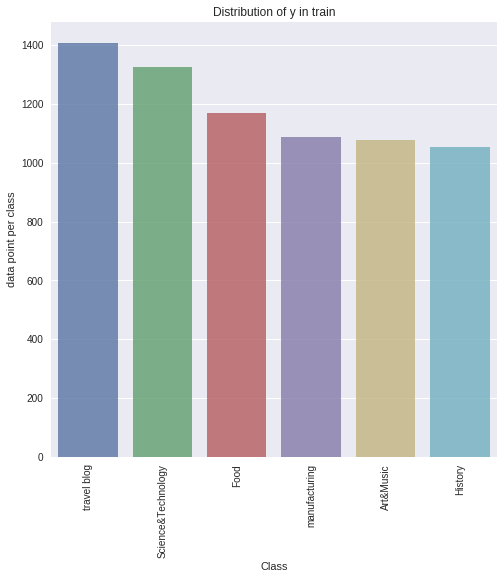

travel blog           440
Science&Technology    415
Food                  366
manufacturing         340
Art&Music             336
History               329
Name: Category, dtype: int64
Distribution of y in test


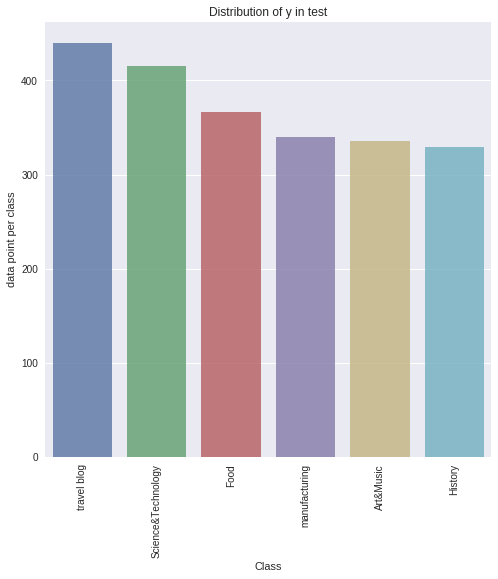

travel blog           352
Science&Technology    332
Food                  293
manufacturing         272
Art&Music             269
History               263
Name: Category, dtype: int64
Distribution of y in cv


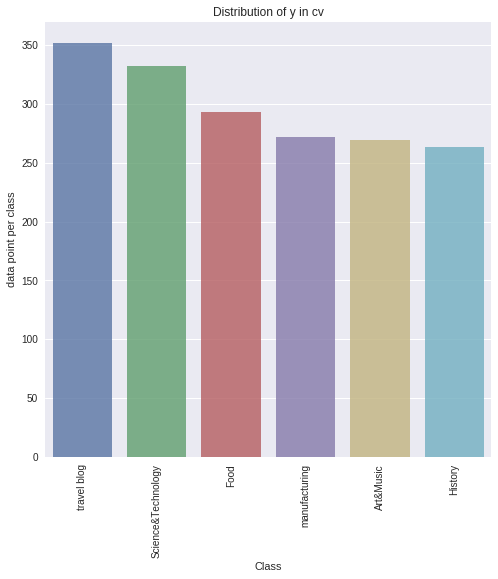

In [15]:
X_trainCategory=train_df['Category'].value_counts()
print(X_trainCategory)
print('Distribution of y in train')
plt.figure(figsize=(8,8))
sns.barplot(X_trainCategory.index, X_trainCategory.values, alpha=0.8)
plt.title('Distribution of y in train')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()




test_dfCategory=test_df['Category'].value_counts()
print(test_dfCategory)
print('Distribution of y in test')
plt.figure(figsize=(8,8))
sns.barplot(test_dfCategory.index,test_dfCategory.values, alpha=0.8)
plt.title('Distribution of y in test')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

cv_dfCategory=cv_df['Category'].value_counts()
print(cv_dfCategory)
print('Distribution of y in cv')
plt.figure(figsize=(8,8))
sns.barplot(cv_dfCategory.index,cv_dfCategory.values, alpha=0.8)
plt.title('Distribution of y in cv')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()


<h2>4. .Text vectorization[BOW,TF-IDF]</h2>

<h4>4.1 Bag of Words (BoW)</h4>

In [0]:
x_tr=train_df['Description']
x_test=test_df['Description']
x_cv=cv_df['Description']

In [0]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)
x_cv_uni= bow.transform(x_cv)

<h4>4.2. TF-IDF</h4>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_cv_tfidf = tf_idf_vect.transform(x_cv)

<h2>5. Machine Learning</h2>

<h3>5.1 Category 1-Linear SVM</h3>

<h4>5.1.1. Unigram(BOW)</h4>

<h4>5.1.1.1 Hypermeter Turning</h4>

0.915300733956047
0.01


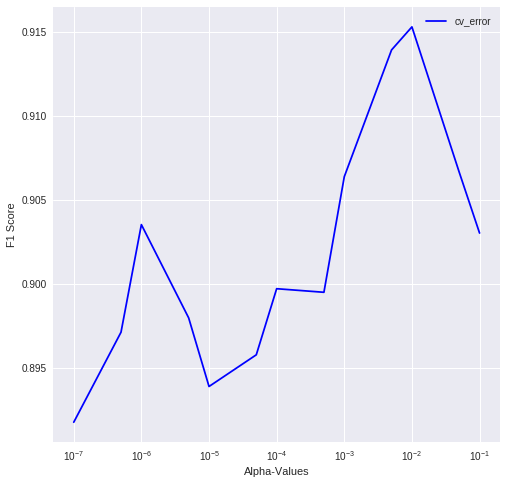

In [19]:
cv_f1score = []
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
    clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
    clf.fit(x_tr_uni,y_train)
    pred = clf.predict(x_cv_uni)
    score = f1_score(y_cv, pred,average='weighted')
    cv_f1score.append(score)

    
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_f1score,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('F1 Score')
plt.legend()
print(max(cv_f1score))
print(a_val[cv_f1score.index(max(cv_f1score))])

<h4>5.1.1.2 Running Model on Training Data using Optimal alpha</h4>

In [0]:
def plotPrecisionRecall(y_test,y_pred):
    C = confusion_matrix(y_test, y_pred)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']


    print("-"*20, "Precision matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Accuracy on test set: 90.836%
Precision on test set: 0.908
Recall on test set: 0.907
F1-Score on test set: 0.907
-------------------- confusion matrix --------------------


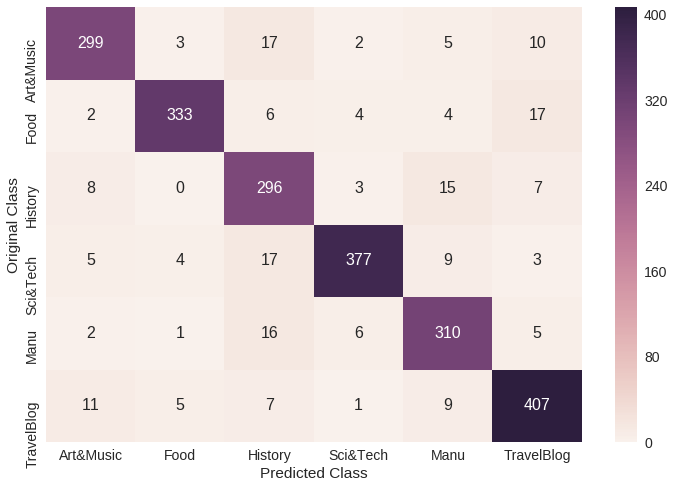

-------------------- Precision matrix --------------------


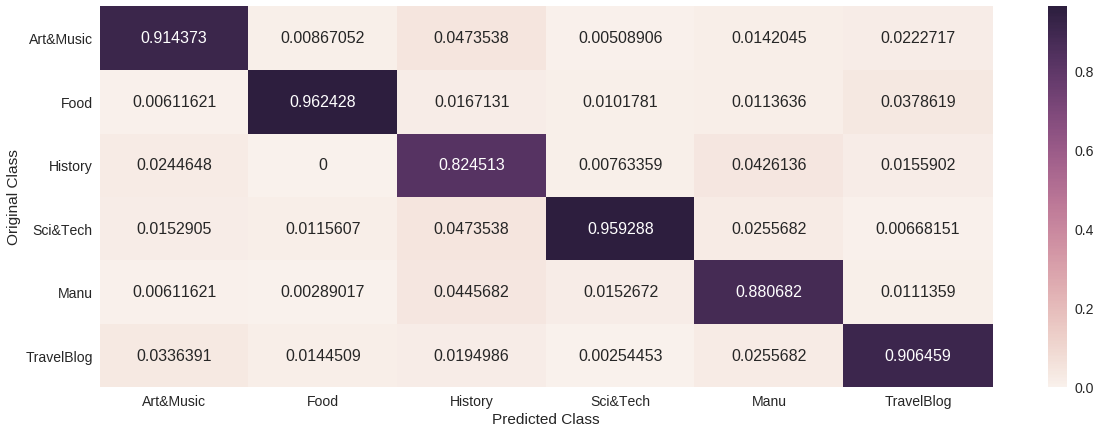

-------------------- Recall matrix --------------------


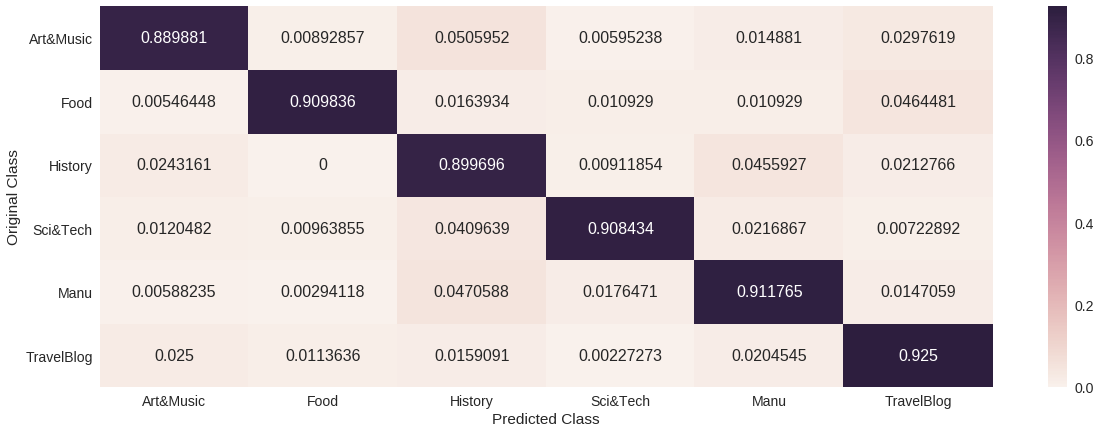

In [21]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.01, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
clf.fit(x_tr_uni,y_train)
y_pred = clf.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix)
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

<h3>Conclusion</h3>
* Travel Blog-407 are correctly classified out of 440 Precision of 91.4% and Recall of 88.981<br>
* Science and Technology-377 are correctly classified out of 415 Precision of 96.2% and Recall of 90.9%<br>
* Food-333 are correctly classified out of 366 Precision of 82.4 % and Recall of 89.9%<br>
* Manufacturing-310 are correctly classified out of 340 Precision of 95.9%  and Recall of 90.8% <br>
* Art & Music-229 are correctly classified out of 336 Precision of 88.0% and Recall of  91.1%<br>
* History-296 are correctly classified out of 329 Precision of 90.6% and Recall of 92.5%<br>

<h4>5.1.2. TF-IDF</h4>

<h4>5.1.2.1 Hypermeter Turning</h4>

0.9277321371691946
0.0001


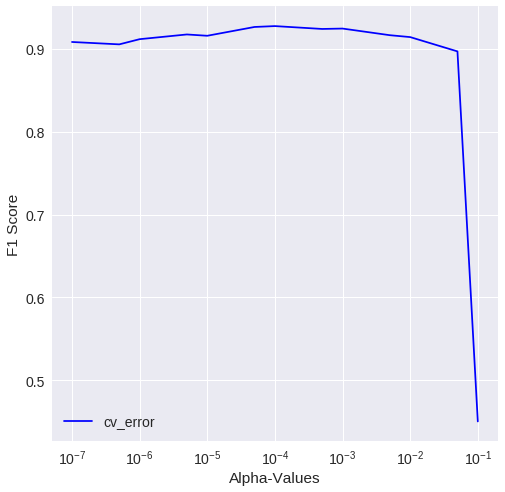

In [22]:
cv_f1score = []
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
for a in a_val:
    clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
    clf.fit(x_tr_tfidf,y_train)
    pred = clf.predict(x_cv_tfidf)
    score = f1_score(y_cv, pred,average='weighted')
    cv_f1score.append(score)

    
a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
plt.figure(figsize=(8,8))
plt.plot(a_val, cv_f1score,label = 'cv_error', color = 'b')
plt.xscale('log')
plt.xlabel('Alpha-Values')
plt.ylabel('F1 Score')
plt.legend()
print(max(cv_f1score))
print(a_val[cv_f1score.index(max(cv_f1score))])

<h4>5.1.2.2 Running Model on Test Data using Optimal alpha</h4>

Accuracy on test set: 92.138%
Precision on test set: 0.920
Recall on test set: 0.920
F1-Score on test set: 0.920
-------------------- confusion matrix --------------------


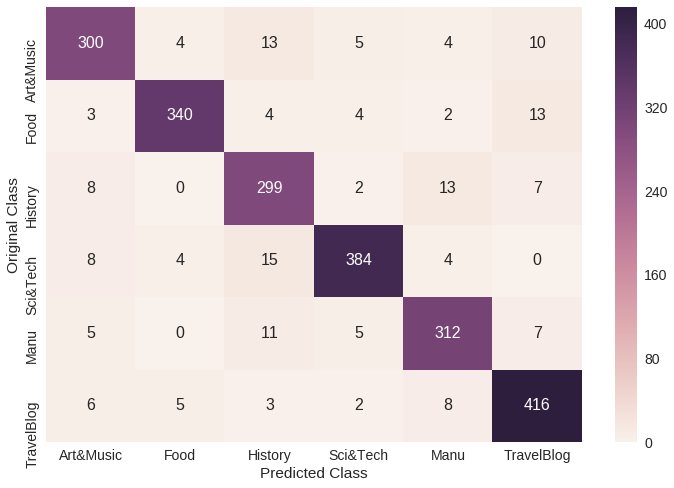

-------------------- Precision matrix --------------------


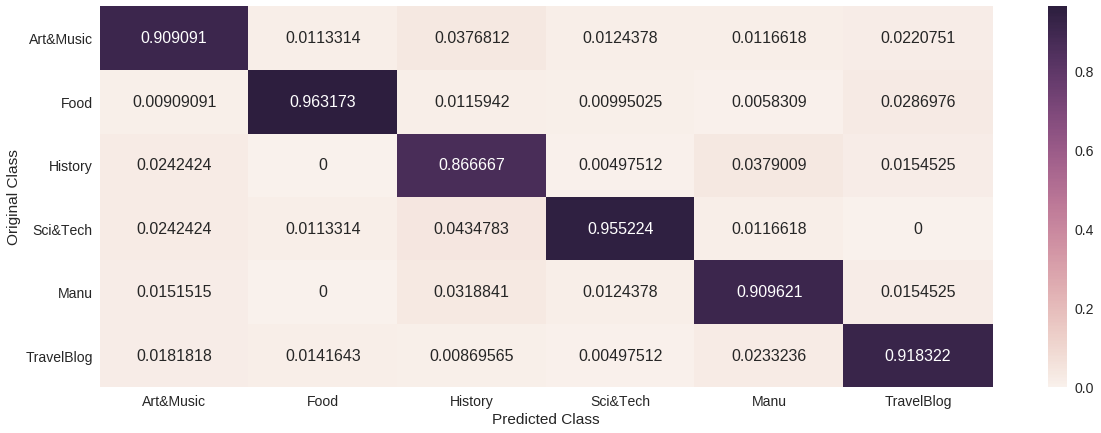

-------------------- Recall matrix --------------------


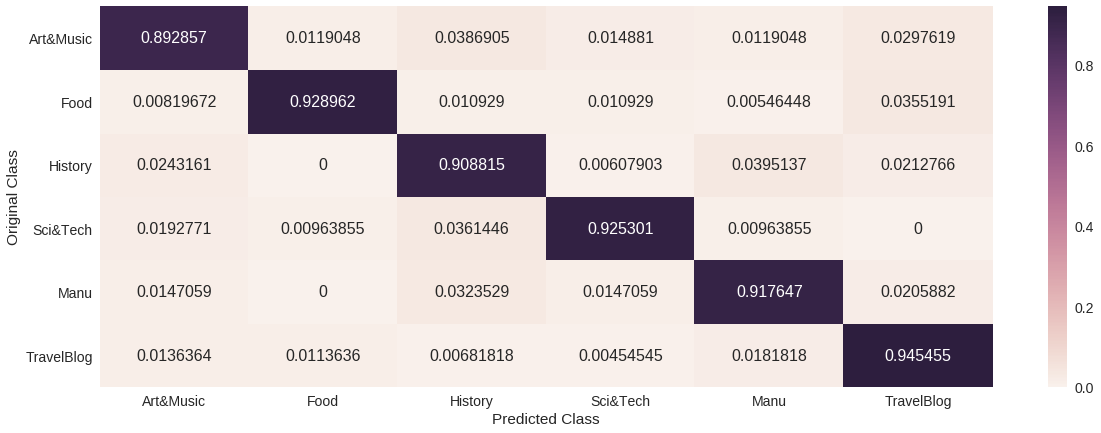

In [24]:
clf = SGDClassifier(loss = 'hinge', alpha =0.0001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
clf.fit(x_tr_tfidf,y_train)
y_pred = clf.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

<h3>Conclusion</h3>
* Travel Blog-416 are correctly classified out of 440 Precision of 90.9% and Recall of 89.2%<br>
* Science and Technology-384 are correctly classified out of 415 Precision of 96.3% and Recall of 92.8%<br>
* Food-340 are correctly classified out of 366 Precision of 86.6 % and Recall of 90.8%<br>
* Manufacturing-312 are correctly classified out of 340 Precision of 95.5%  and Recall of 92.5% <br>
* Art & Music-300 are correctly classified out of 336 Precision of 90.9% and Recall of  91.7%<br>
* History-299 are correctly classified out of 329 Precision of 91.8% and Recall of 94.5%<br>

<h4>5.1.3. LinearSVM Conclusion</h4>

|Model |hyper parameter|F1-score cv|F1-score test|Precision test|Recall test|Accuracy Test|
|------|------|------|------|------|------|------|
|unigram  | 0.01|0.927|0.907|0.908|0.907|90.836%|
| TF-IDF | 0.0001|0.922|0.920|0.920|0.920|92.138%|

<h3>5.2 Category 2-Bagging(Random Forest)</h3>

<h4>5.2.1. Splitting data into train,test (80:20)</h4>

In [0]:
y_true = data['Category'].values
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)

<h4>5.2.2. BOW,TF-IDF</h4>

In [0]:
x_tr=X_train['Description']
x_test=test_df['Description']

<h4>5.2.2.1 BOW</h4>

In [0]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

<h4>5.2.2.1 TF-IDF</h4>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

<h2>5.2.3 BOW</h2>

<h4>5.2.3.1 Finding the optimal nEstimator & Depth using gridsearch</h4>

Fitting 5 folds for each of 272 candidates, totalling 1360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 1360 out of 1360 | elapsed: 25.1min finished


Best HyperParameter:  {'max_depth': 130, 'n_estimators': 16}
0.8680279978746961


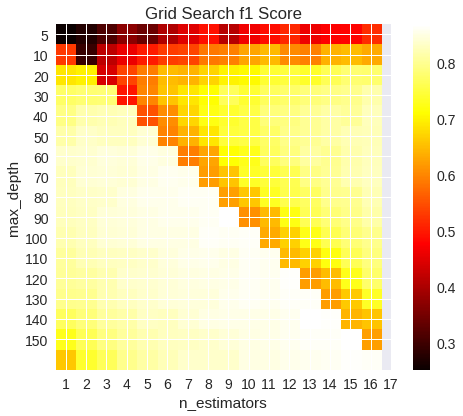

In [0]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_uni,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

<h4>5.2.3.2 Finding the accuracy,F1-score in Test data using optimal n_estimators,max_depth</h4>

Accuracy on test set: 86.119%
Precision on test set: 0.860
Recall on test set: 0.858
F1-Score on test set: 0.858
-------------------- confusion matrix --------------------


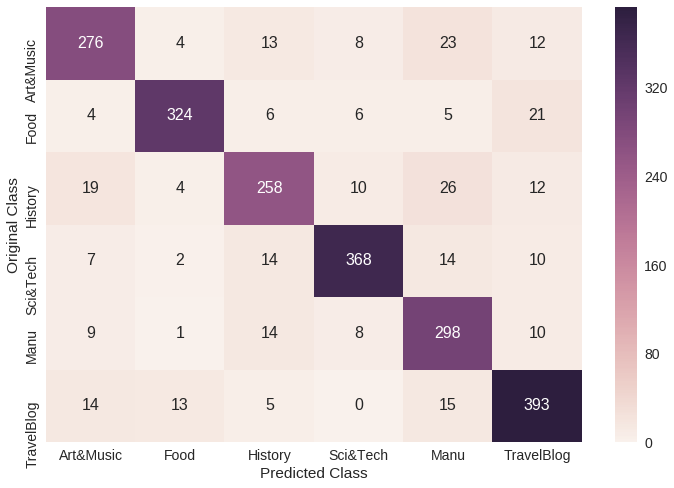

-------------------- Precision matrix --------------------


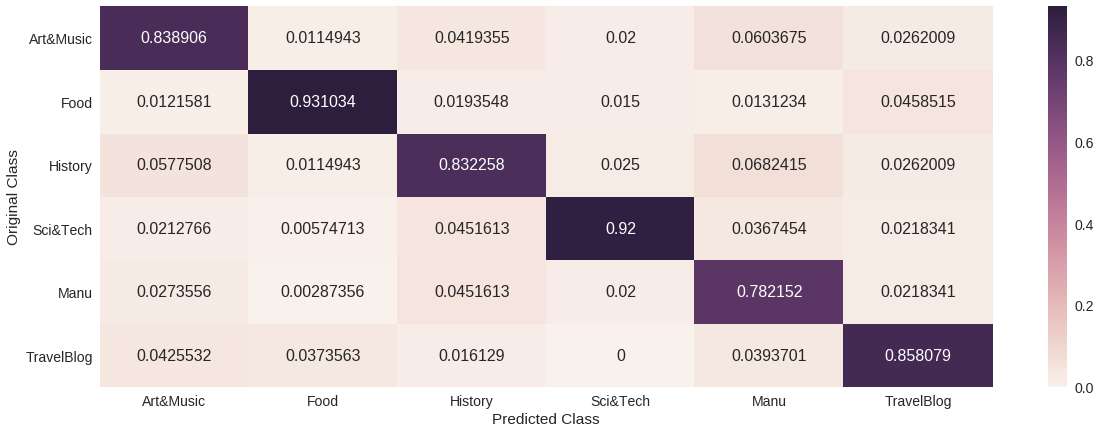

-------------------- Recall matrix --------------------


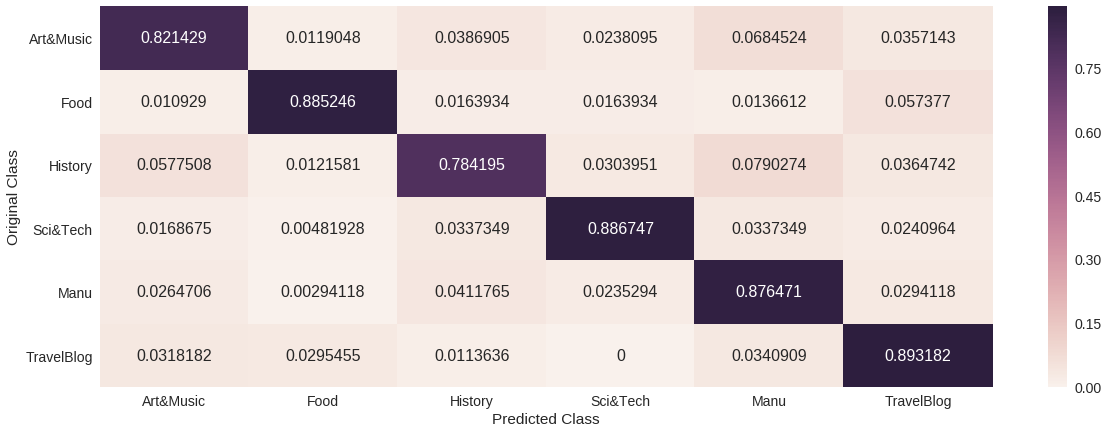

In [42]:
RF= RandomForestClassifier(n_estimators=16,max_depth=130)
RF.fit(x_tr_uni,y_train)
y_pred =RF.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)


<h3>Conclusion</h3>
* Travel Blog-393 are correctly classified out of 440 Precision of 89.3% and Recall of 89.3%<br>
* Science and Technology-368 are correctly classified out of 415 Precision of 92% and Recall of 88.6%<br>
* Food-324 are correctly classified out of 366 Precision of 93% and Recall of 88.5%<br>
* Manufacturing-298 are correctly classified out of 340 Precision of 78.2%  and Recall of 87.6% <br>
* Art & Music-276 are correctly classified out of 336 Precision of 83.8% and Recall of  82.1%<br>
* History-258 are correctly classified out of 329 Precision of 83.2% and Recall of 78.4%<br>

<h2>5.2.4 TF-IDF</h2>

<h4>5.2.4.1 Finding the optimal nEstimator & Depth using gridsearch</h4>

In [0]:
nEstimator = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
depth = [40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

RF = RandomForestClassifier()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tfidf,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

Fitting 5 folds for each of 272 candidates, totalling 1360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   5.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  25.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  53.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 120.5min
[Parallel(n_jobs=-1)]: Done 1360 out of 1360 | elapsed: 264.7min finished
Best HyperParameter:  {'max_depth': 190, 'n_estimators': 20}
0.8727278978746147


<h4>5.2.4.2 Finding the accuracy,F1-score in Test data using optimal n_estimators,max_depth</h4>

Accuracy on test set: 85.085%
Precision on test set: 0.854
Recall on test set: 0.848
F1-Score on test set: 0.849
-------------------- confusion matrix --------------------


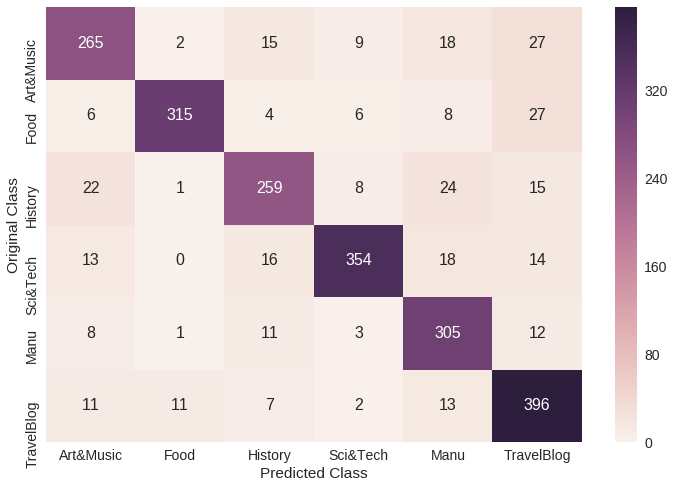

-------------------- Precision matrix --------------------


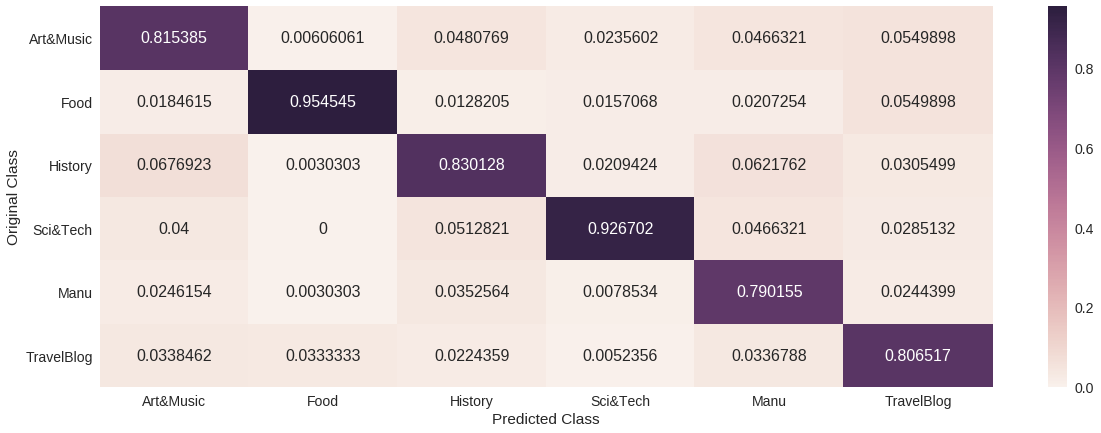

-------------------- Recall matrix --------------------


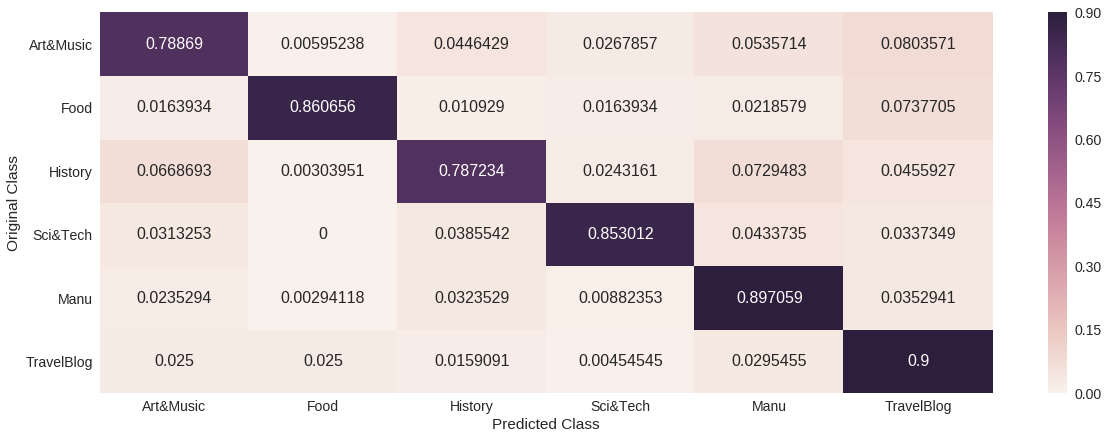

In [30]:
RF= RandomForestClassifier(n_estimators=20,max_depth=190)
RF.fit(x_tr_tfidf,y_train)
y_pred =RF.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

plotPrecisionRecall(y_test,y_pred)

<h3>Conclusion</h3>
* Travel Blog-396 are correctly classified out of 440 Precision of 80.6% and Recall of 90.0%<br>
* Science and Technology-354 are correctly classified out of 415 Precision of 92.6% and Recall of 85.3%<br>
* Food-315 are correctly classified out of 366 Precision of 95.4% and Recall of 86.0%<br>
* Manufacturing-305 are correctly classified out of 340 Precision of 79.0%  and Recall of 89.7% <br>
* Art & Music-265 are correctly classified out of 336 Precision of 81.5% and Recall of  78.8%<br>
* History-259 are correctly classified out of 329 Precision of 83.1% and Recall of 78.7%<br>

<h2>5.2.4 Random Forest Conclusion </h2>

|Model |n_estimators|Max Depth|F1-score cv|F1-score test|Precision test|Recall test|Accuracy Test|
|------|------|------|------|------|------|------|------|
|unigram|16|130|0.868|0.858|0.860|0.858|86.119%|
|TF-IDF|20|190|0.872|0.849|0.854|0.848|85.085%|

# 6.Final Conclusion
<p style="font-size:24px;text-align:center">Support Vector Machine</p>

|Model |hyper parameter|F1-score cv|F1-score test|Precision test|Recall test|Accuracy Test|
|------|------|------|------|------|------|------|
|unigram  | 0.01|0.927|0.907|0.908|0.907|90.836%|
| TF-IDF | 0.0001|0.922|0.920|0.920|0.920|92.138%|

<p style="font-size:24px;text-align:center">Random Forest</p>

|Model |n_estimators|Max Depth|F1-score cv|F1-score test|Precision test|Recall test|Accuracy Test|
|------|------|------|------|------|------|------|------|
|unigram|16|130|0.868|0.858|0.860|0.858|86.119%|
|TF-IDF|20|190|0.872|0.849|0.854|0.848|85.085%|
